<a id="up"></a>

# Description du Notebook
-------------
**Objectifs** : Visualiser les données patient par patient puis dans leur ensemble. Repérer les données extrêmes et les corriger.

**Visualisation des données** : Scatter plots, Heatmap

## Sommaire
-------------
- [Import des données et des packages](#import)
- [Intervalles Âge](#interval-age)
- [Scatter plots](#scatter)
- [Interprétation des résultats](#scatter-interpret)
- [Scatter plot : Taille ~ Âge (> 20 ans)](#scatter02)
- [Heatmap : Taille ~ Âge (> 20 ans)](#heatmap)
- [À Faire](#to-do)


<a id="import"></a>

## Import des données et des packages [(^)](#up)
--------------

In [1]:
import pandas as pd
import numpy as np
import timeit
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import seaborn as sns

start = timeit.default_timer()

# Load data
# LOX-PC : 
data = pd.read_csv('mean_std.csv', dtype={'Taille' : float, 'Appli_origine' : str, 'mean' : float, 'std' : float, 'sem' : float}, na_values = '')

<a id="interval-age"></a>

## Intervalles Âge [(^)](#up)
---------------

In [2]:
# //// Taille : m -> cm
data["Taille"] = data["Taille"] *100

# //// Intervalles Age
age20 = list(range(20 *365)) # Croissance ~ de 0 à 20 ans
age20_40 = list(range((20 *365), (40 *365))) # Stagnation de 0 à 40 ans 
age40_70 = list(range((40 *365), (70 *365))) # Diminution taille à partir de 40 ans
age70plus = list(range((70 *365) , (110 *365)))

# //// Separation en groupe selon les intervalles d'age
data20 = data[data['age_at_entry'].isin(age20)]
data20.to_csv("data20.csv", index=False)
data20_40 = data[data['age_at_entry'].isin(age20_40)]
data40_70 = data[data['age_at_entry'].isin(age40_70)]
data70 = data[data['age_at_entry'].isin(age70plus)]

data20_70 = data[data['age_at_entry'].isin(age20_40 + age40_70 + age70plus)]

<a id="scatter"></a>

## Scatter plots 3x3 [(^)](#up)
---------------------


Premier scatter plot


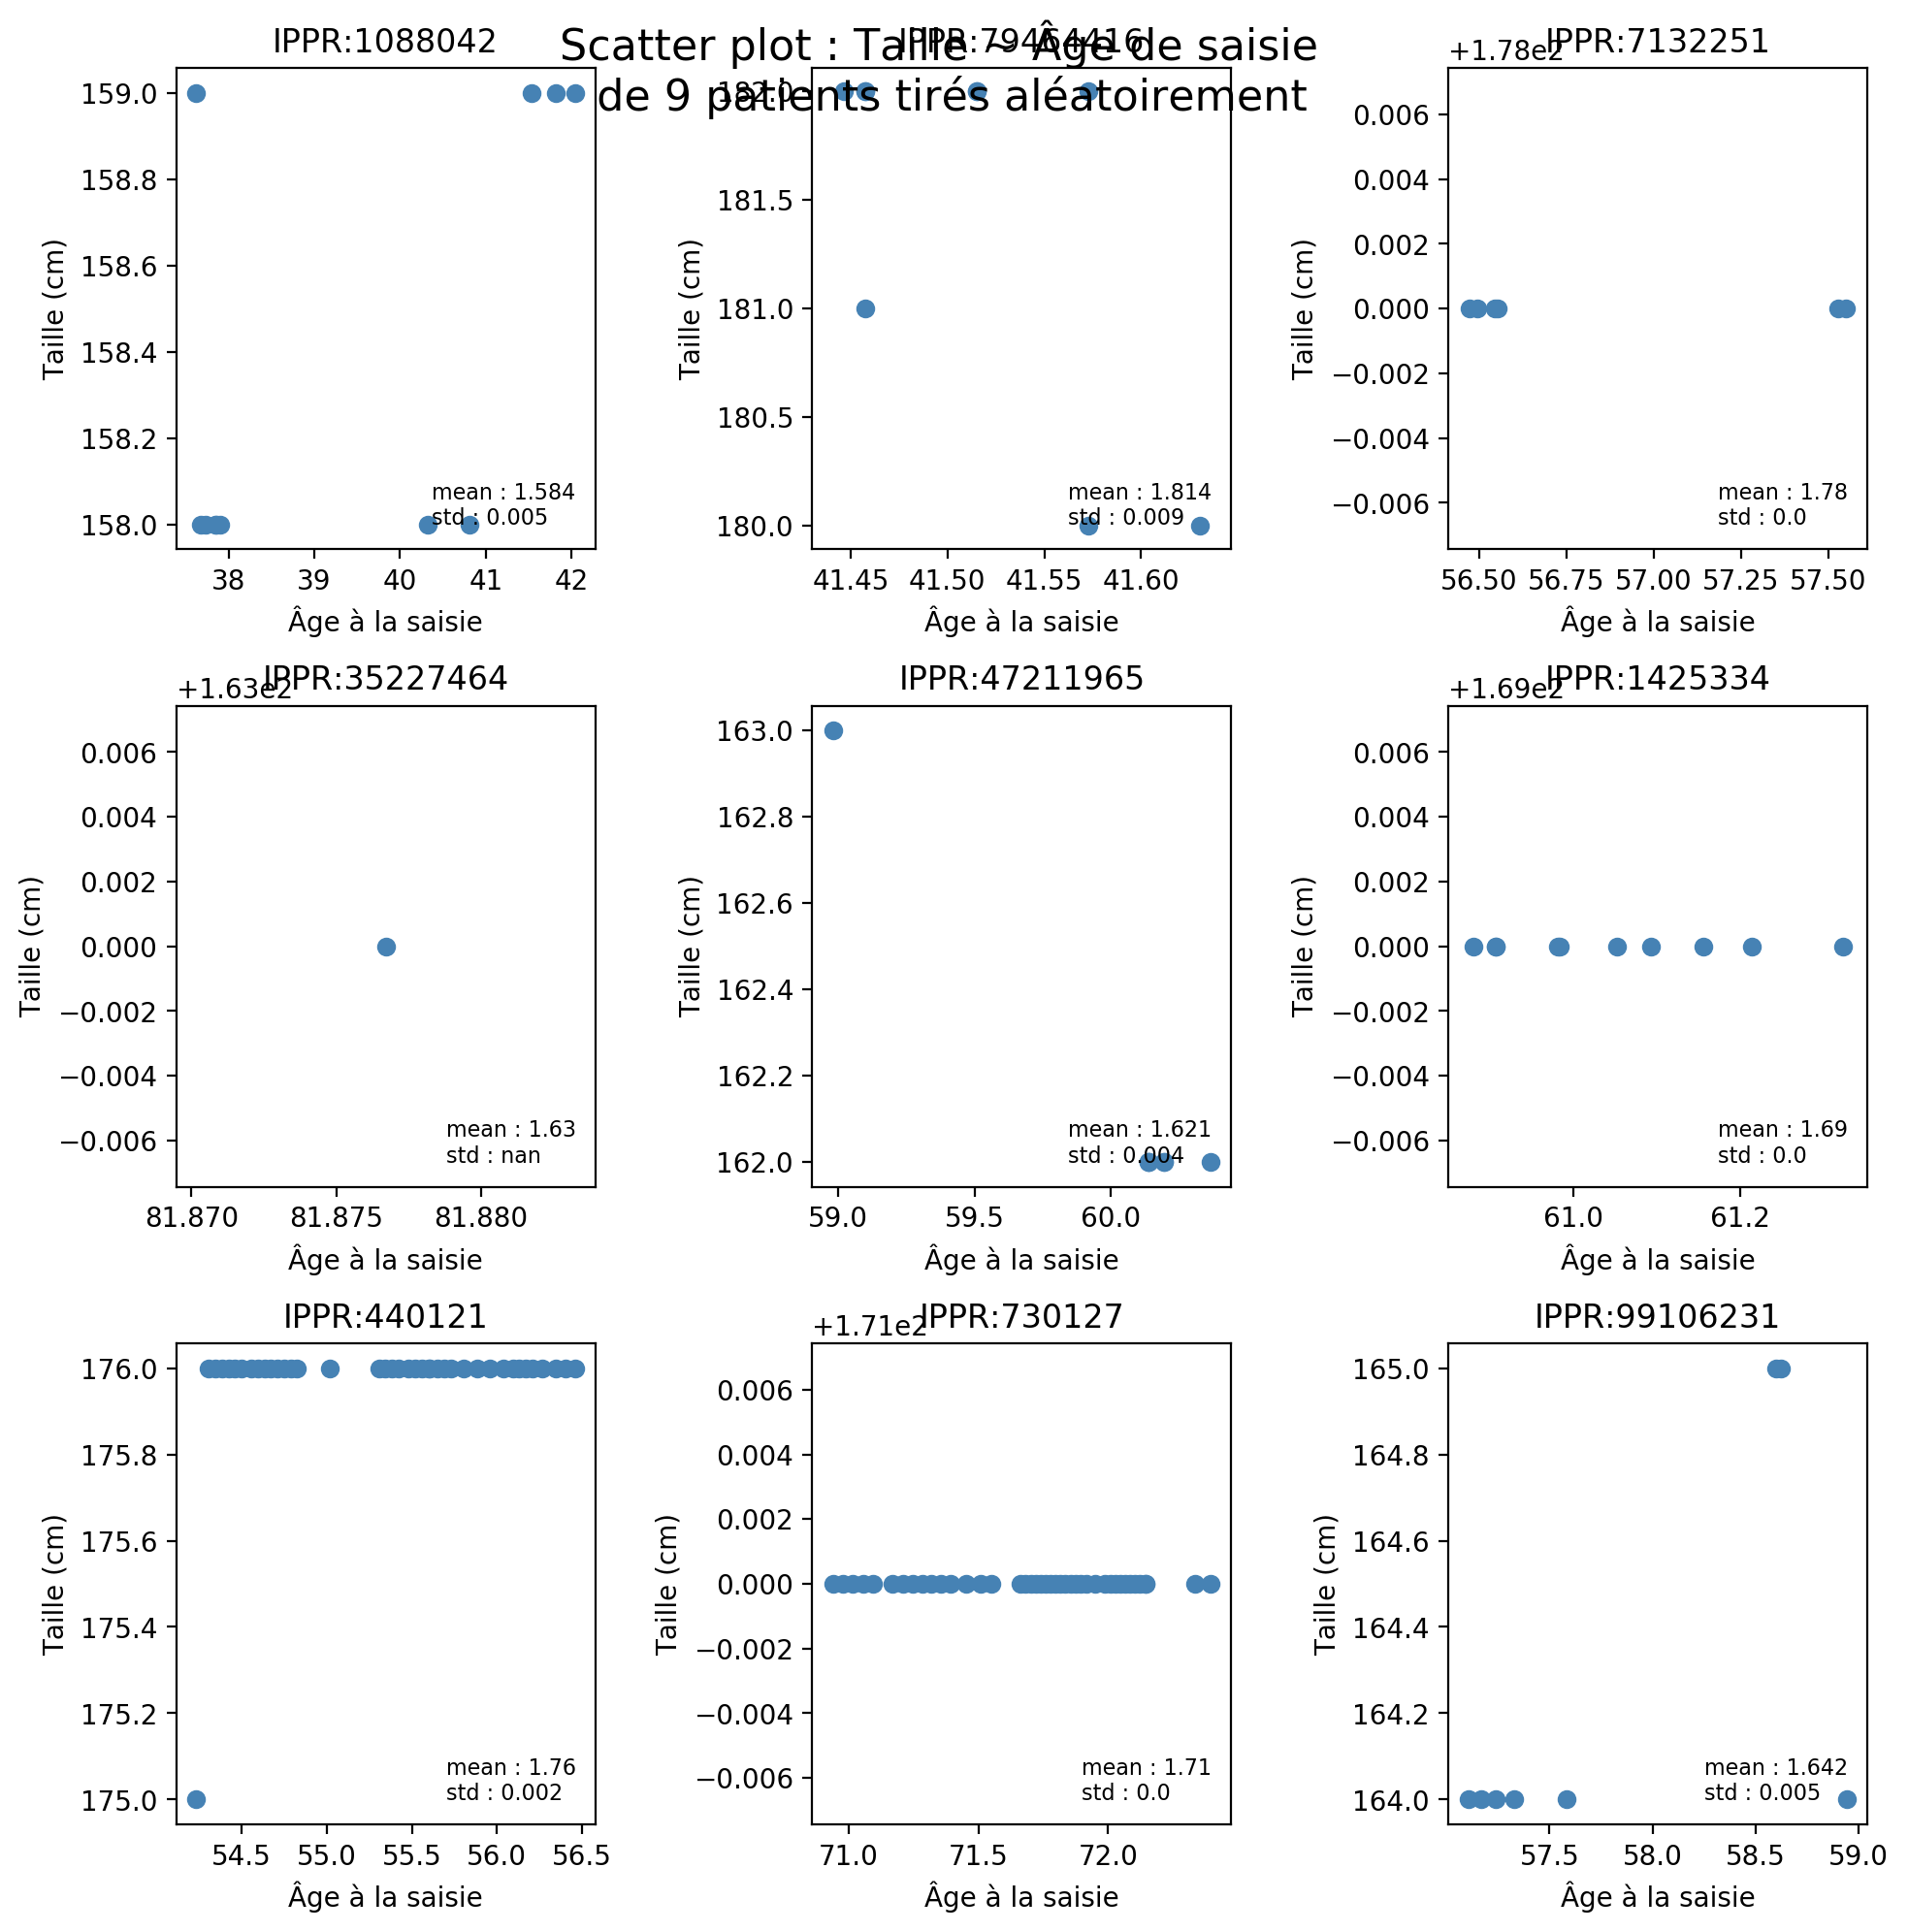


Second scatter plot


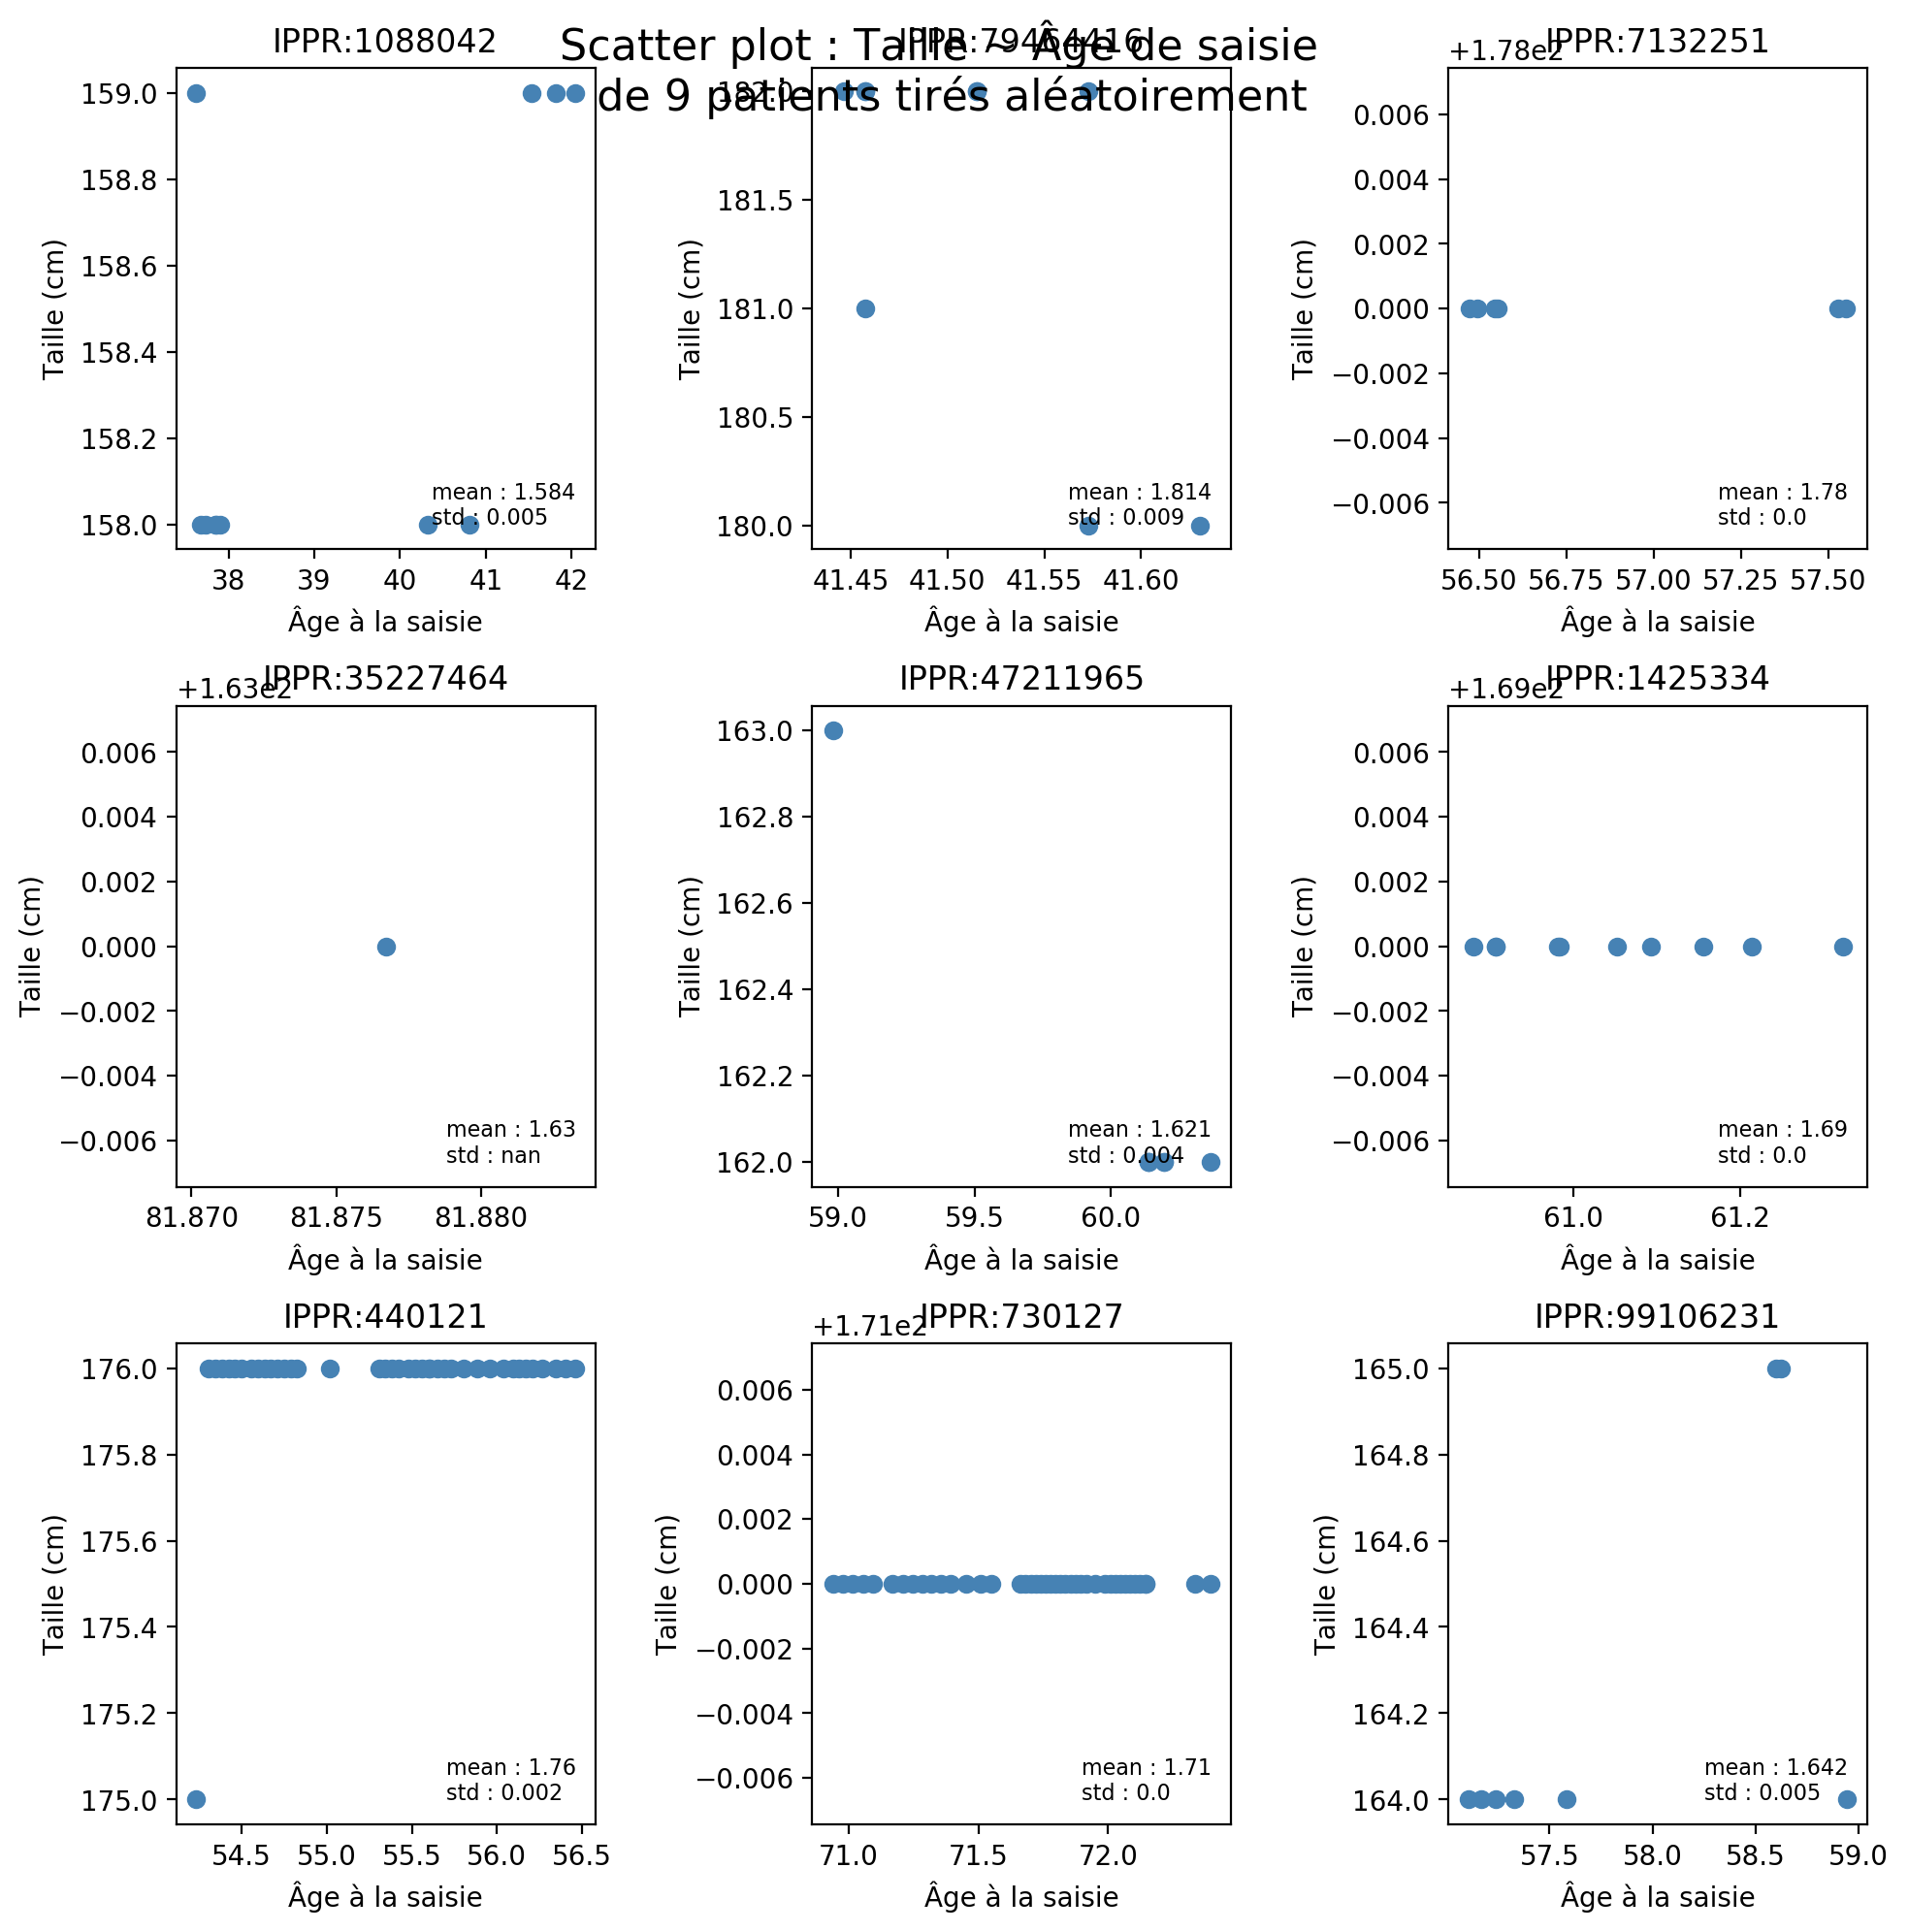


Troisième scatter plot


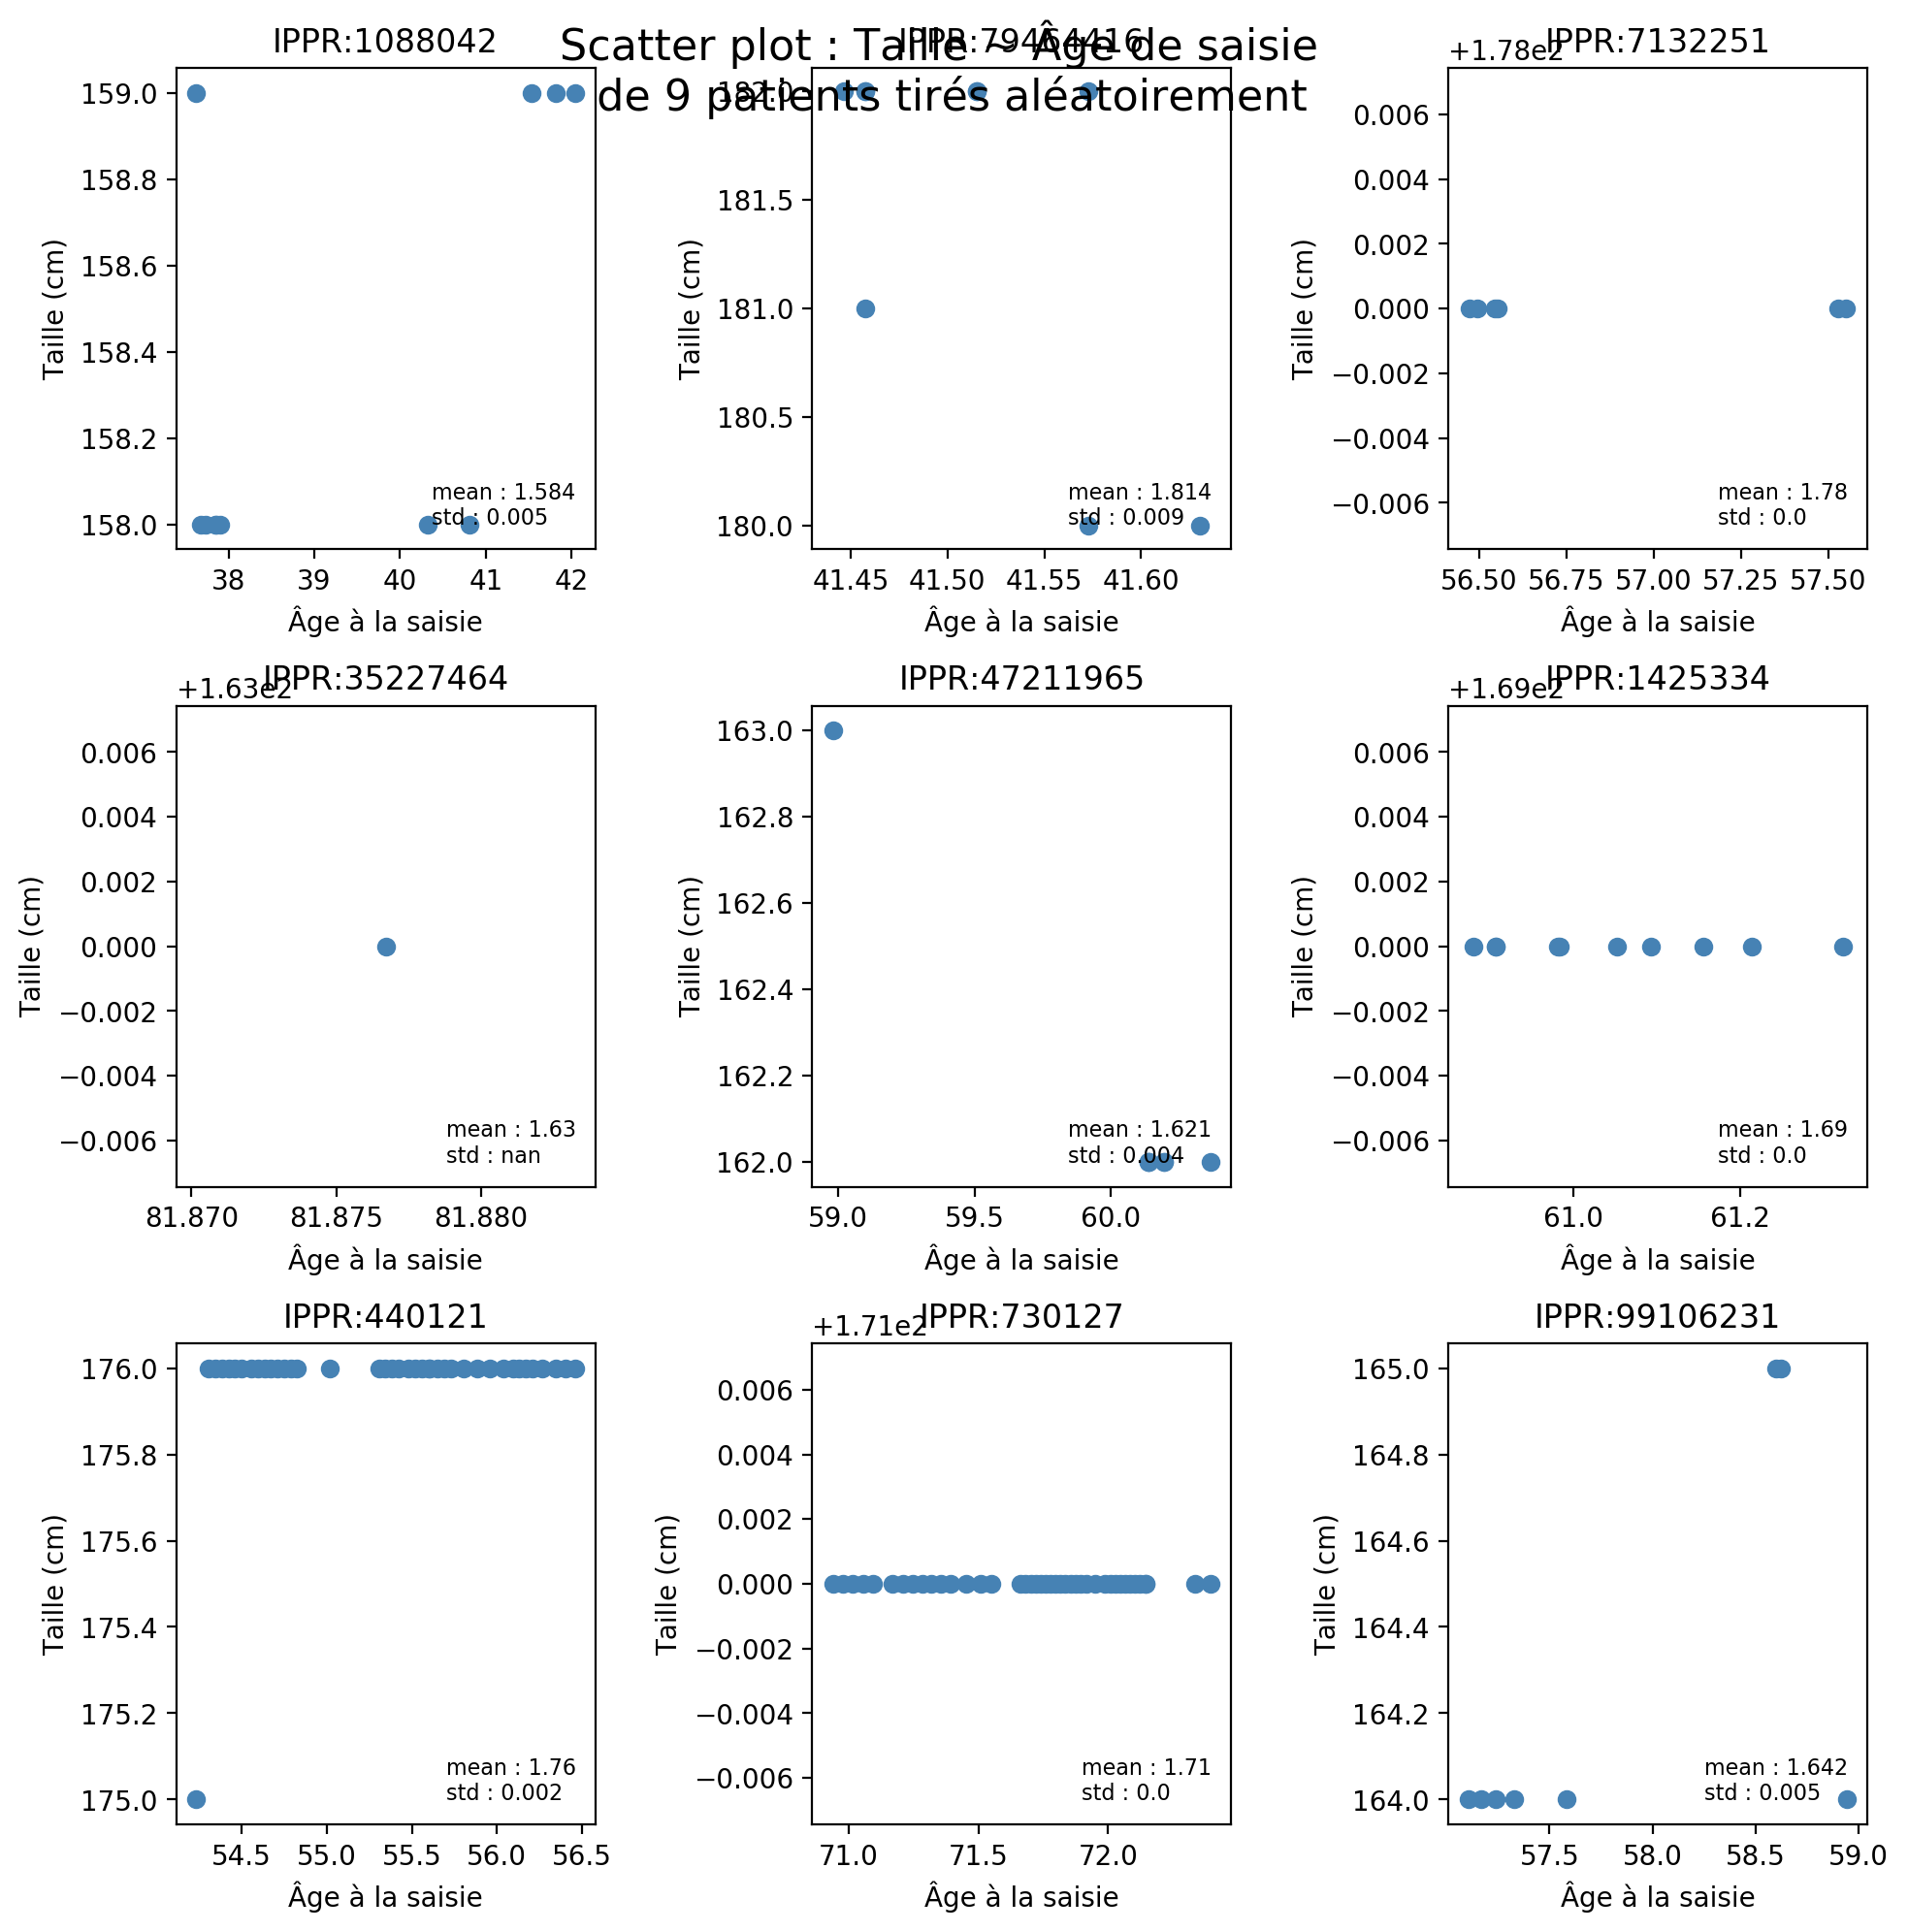

In [3]:
# //// Scatter plots 3x3 de 9 patients choisis aléatoirements
sample_ippr = data['IPPR'].sample(n=9)
sample_ippr = np.array(sample_ippr)
data_sample = data[data["IPPR"].isin(sample_ippr)]

def scatter_3by3(df):
    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=[10, 10], dpi=200)
    for i, axi in enumerate(ax.flat):
        ippri = sample_ippr[i]
        datai = df[df['IPPR'] == ippri]
        xi = datai['age_at_entry'] / 365
        yi = datai['Taille']
        axi.scatter(xi, yi, c='steelblue')
        if (ippri in data20['IPPR'].values):
            axi.set_title("IPPR:"+ str(ippri) + " (<20 ans)")
            axi.set_ylabel("Taille (cm)")
            axi.set_xlabel("Âge à la saisie")
        else:
            axi.set_title("IPPR:"+ str(ippri))
            axi.set_ylabel("Taille (cm)")
            axi.set_xlabel("Âge à la saisie")
        meani = datai['mean'].unique()
        stdi = datai['std'].unique()
        m_s_lbl = "mean : " + str(round(meani[0],3)) + "\nstd : " + str(round(stdi[0],3))
        at = AnchoredText(m_s_lbl,
                  prop=dict(size=8), frameon=False,
                  loc='lower right',
                  )
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        axi.add_artist(at)
        
    plt.suptitle("Scatter plot : Taille ~ Âge de saisie \n de 9 patients tirés aléatoirement", y=0.99, size=16)
    plt.tight_layout(pad=1)
    plt.show()

print("\nPremier scatter plot")
scatter_3by3(data_sample)
print("\nSecond scatter plot")
scatter_3by3(data_sample)
print("\nTroisième scatter plot")
scatter_3by3(data_sample)

<a id="scatter-interpret"></a>

## Interprétation des résultats [(^)](#up)
------------------

<a id="scatter02"></a>

## Scatter Plot > 20 ans [(^)](#up)
------------------
Scatter plot de toute les données de taille pour les patients de plus de 20 ans. 

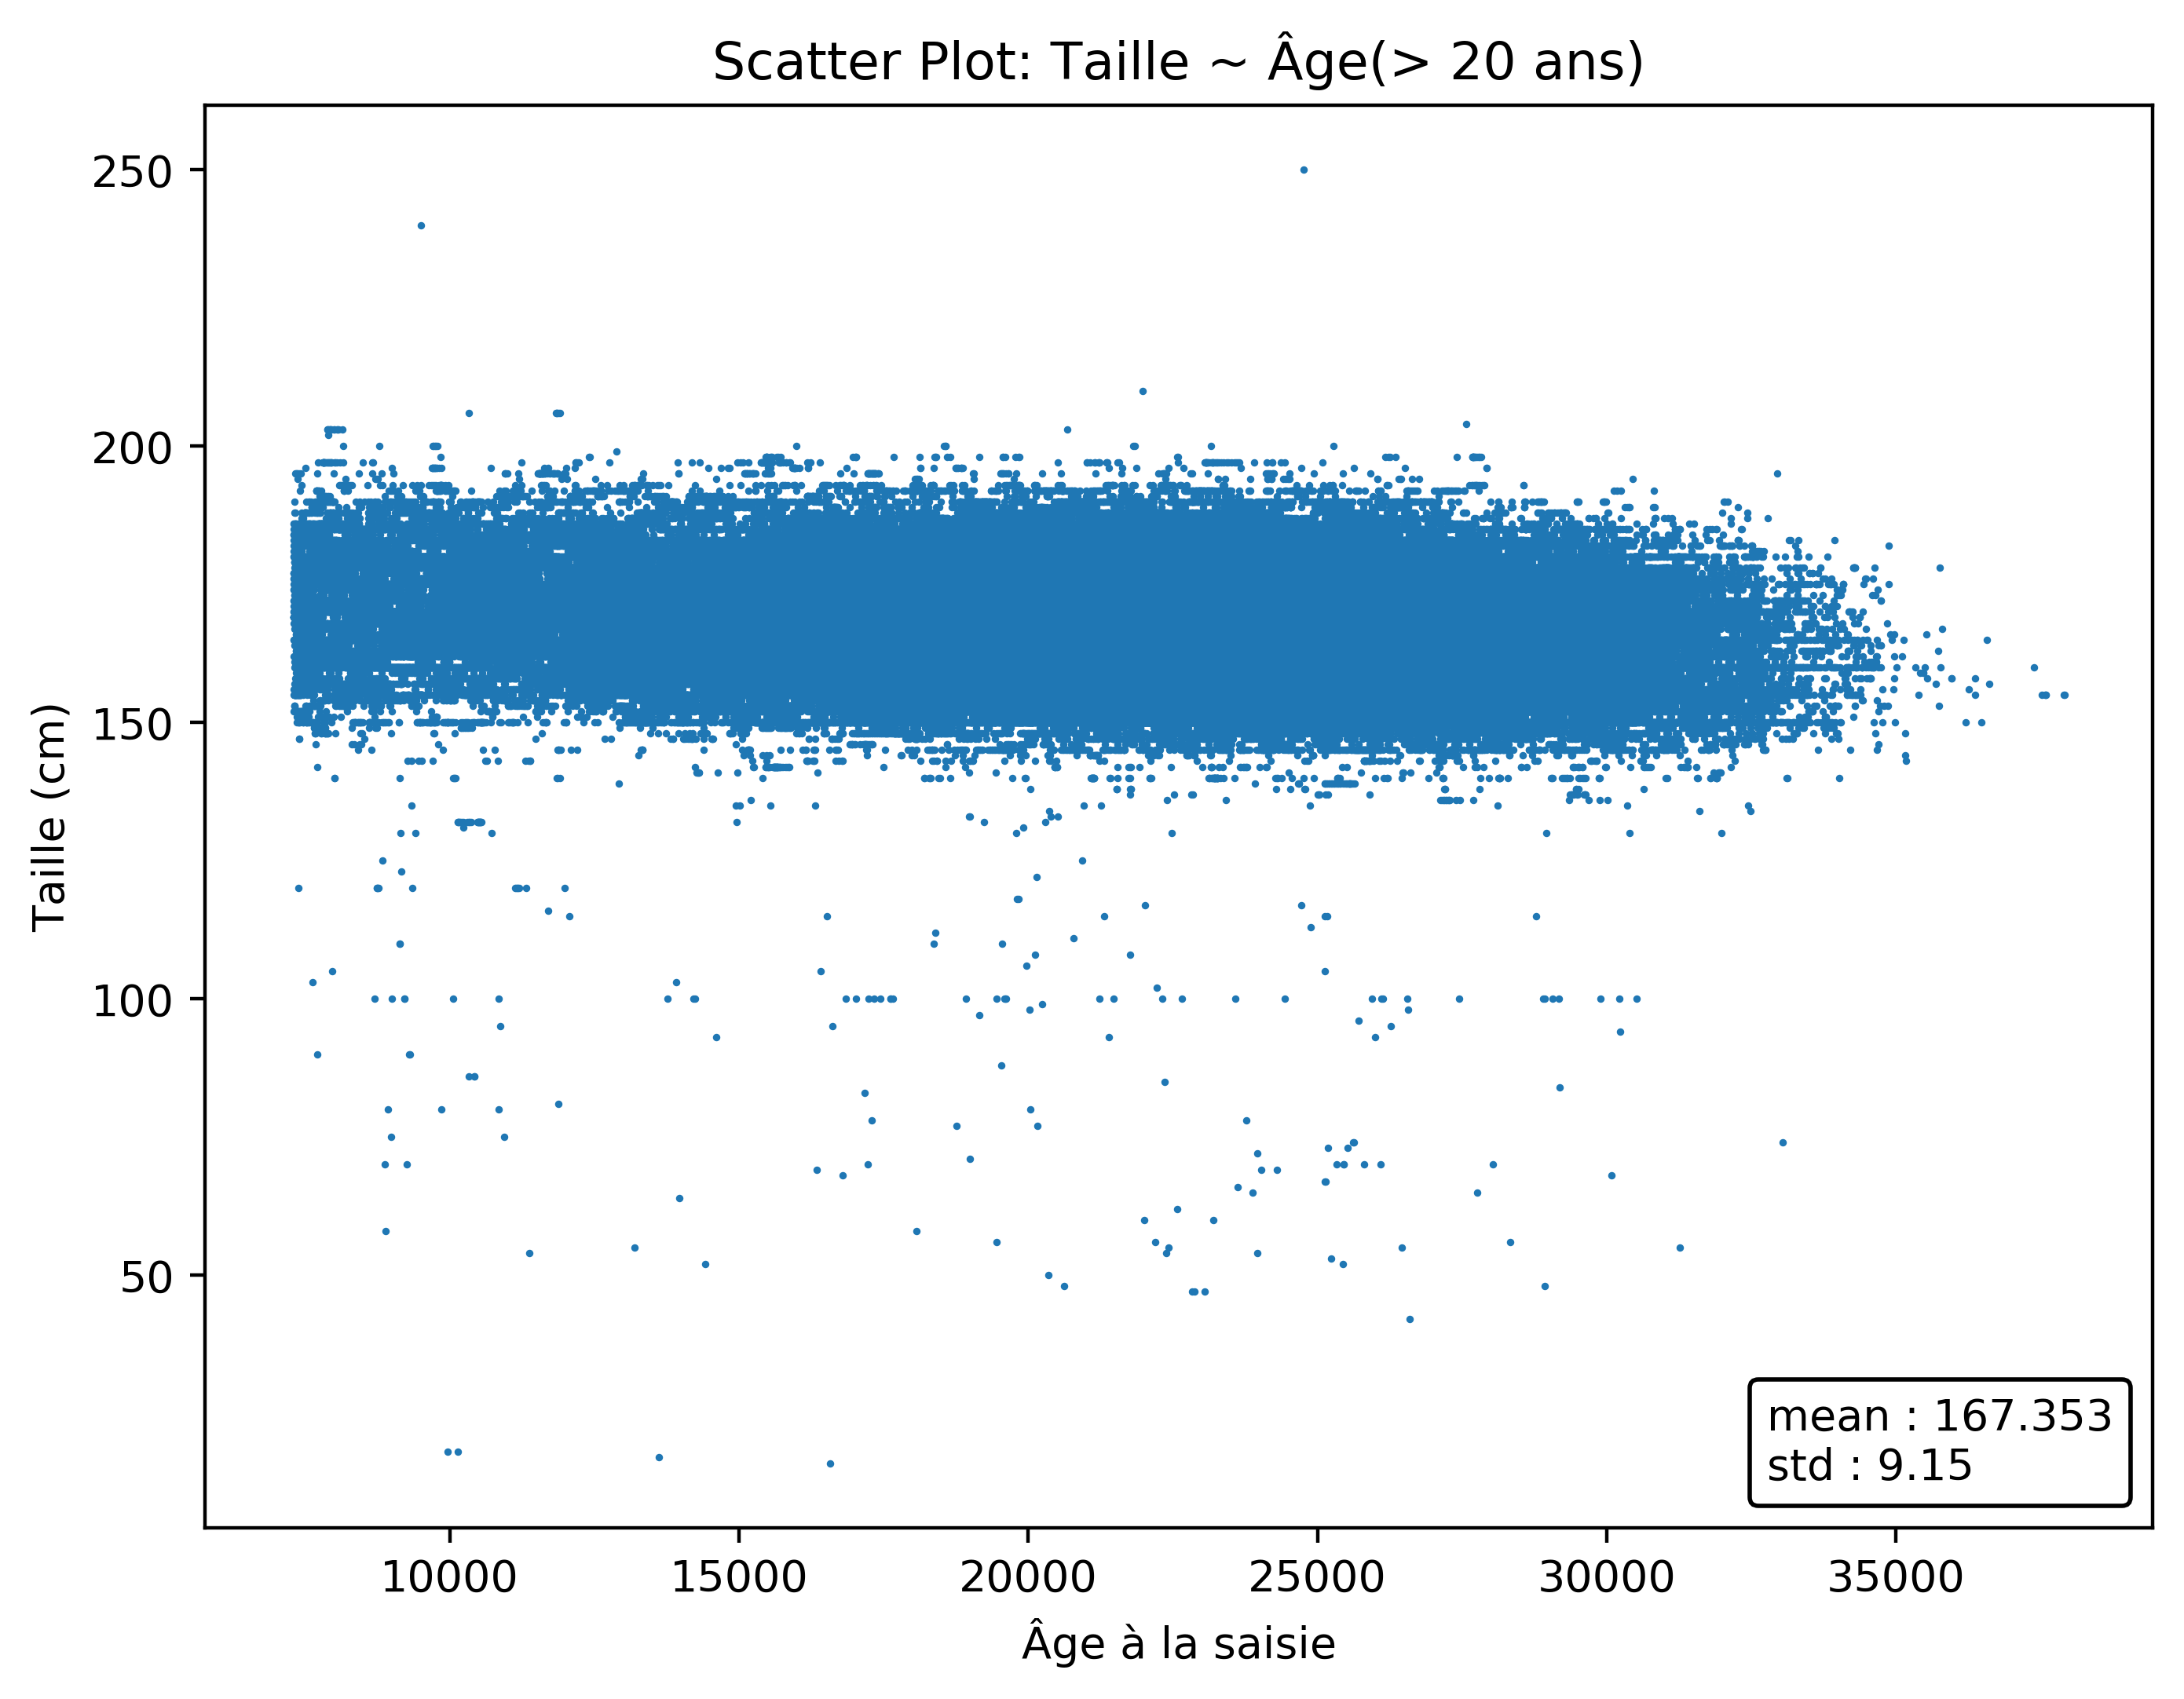

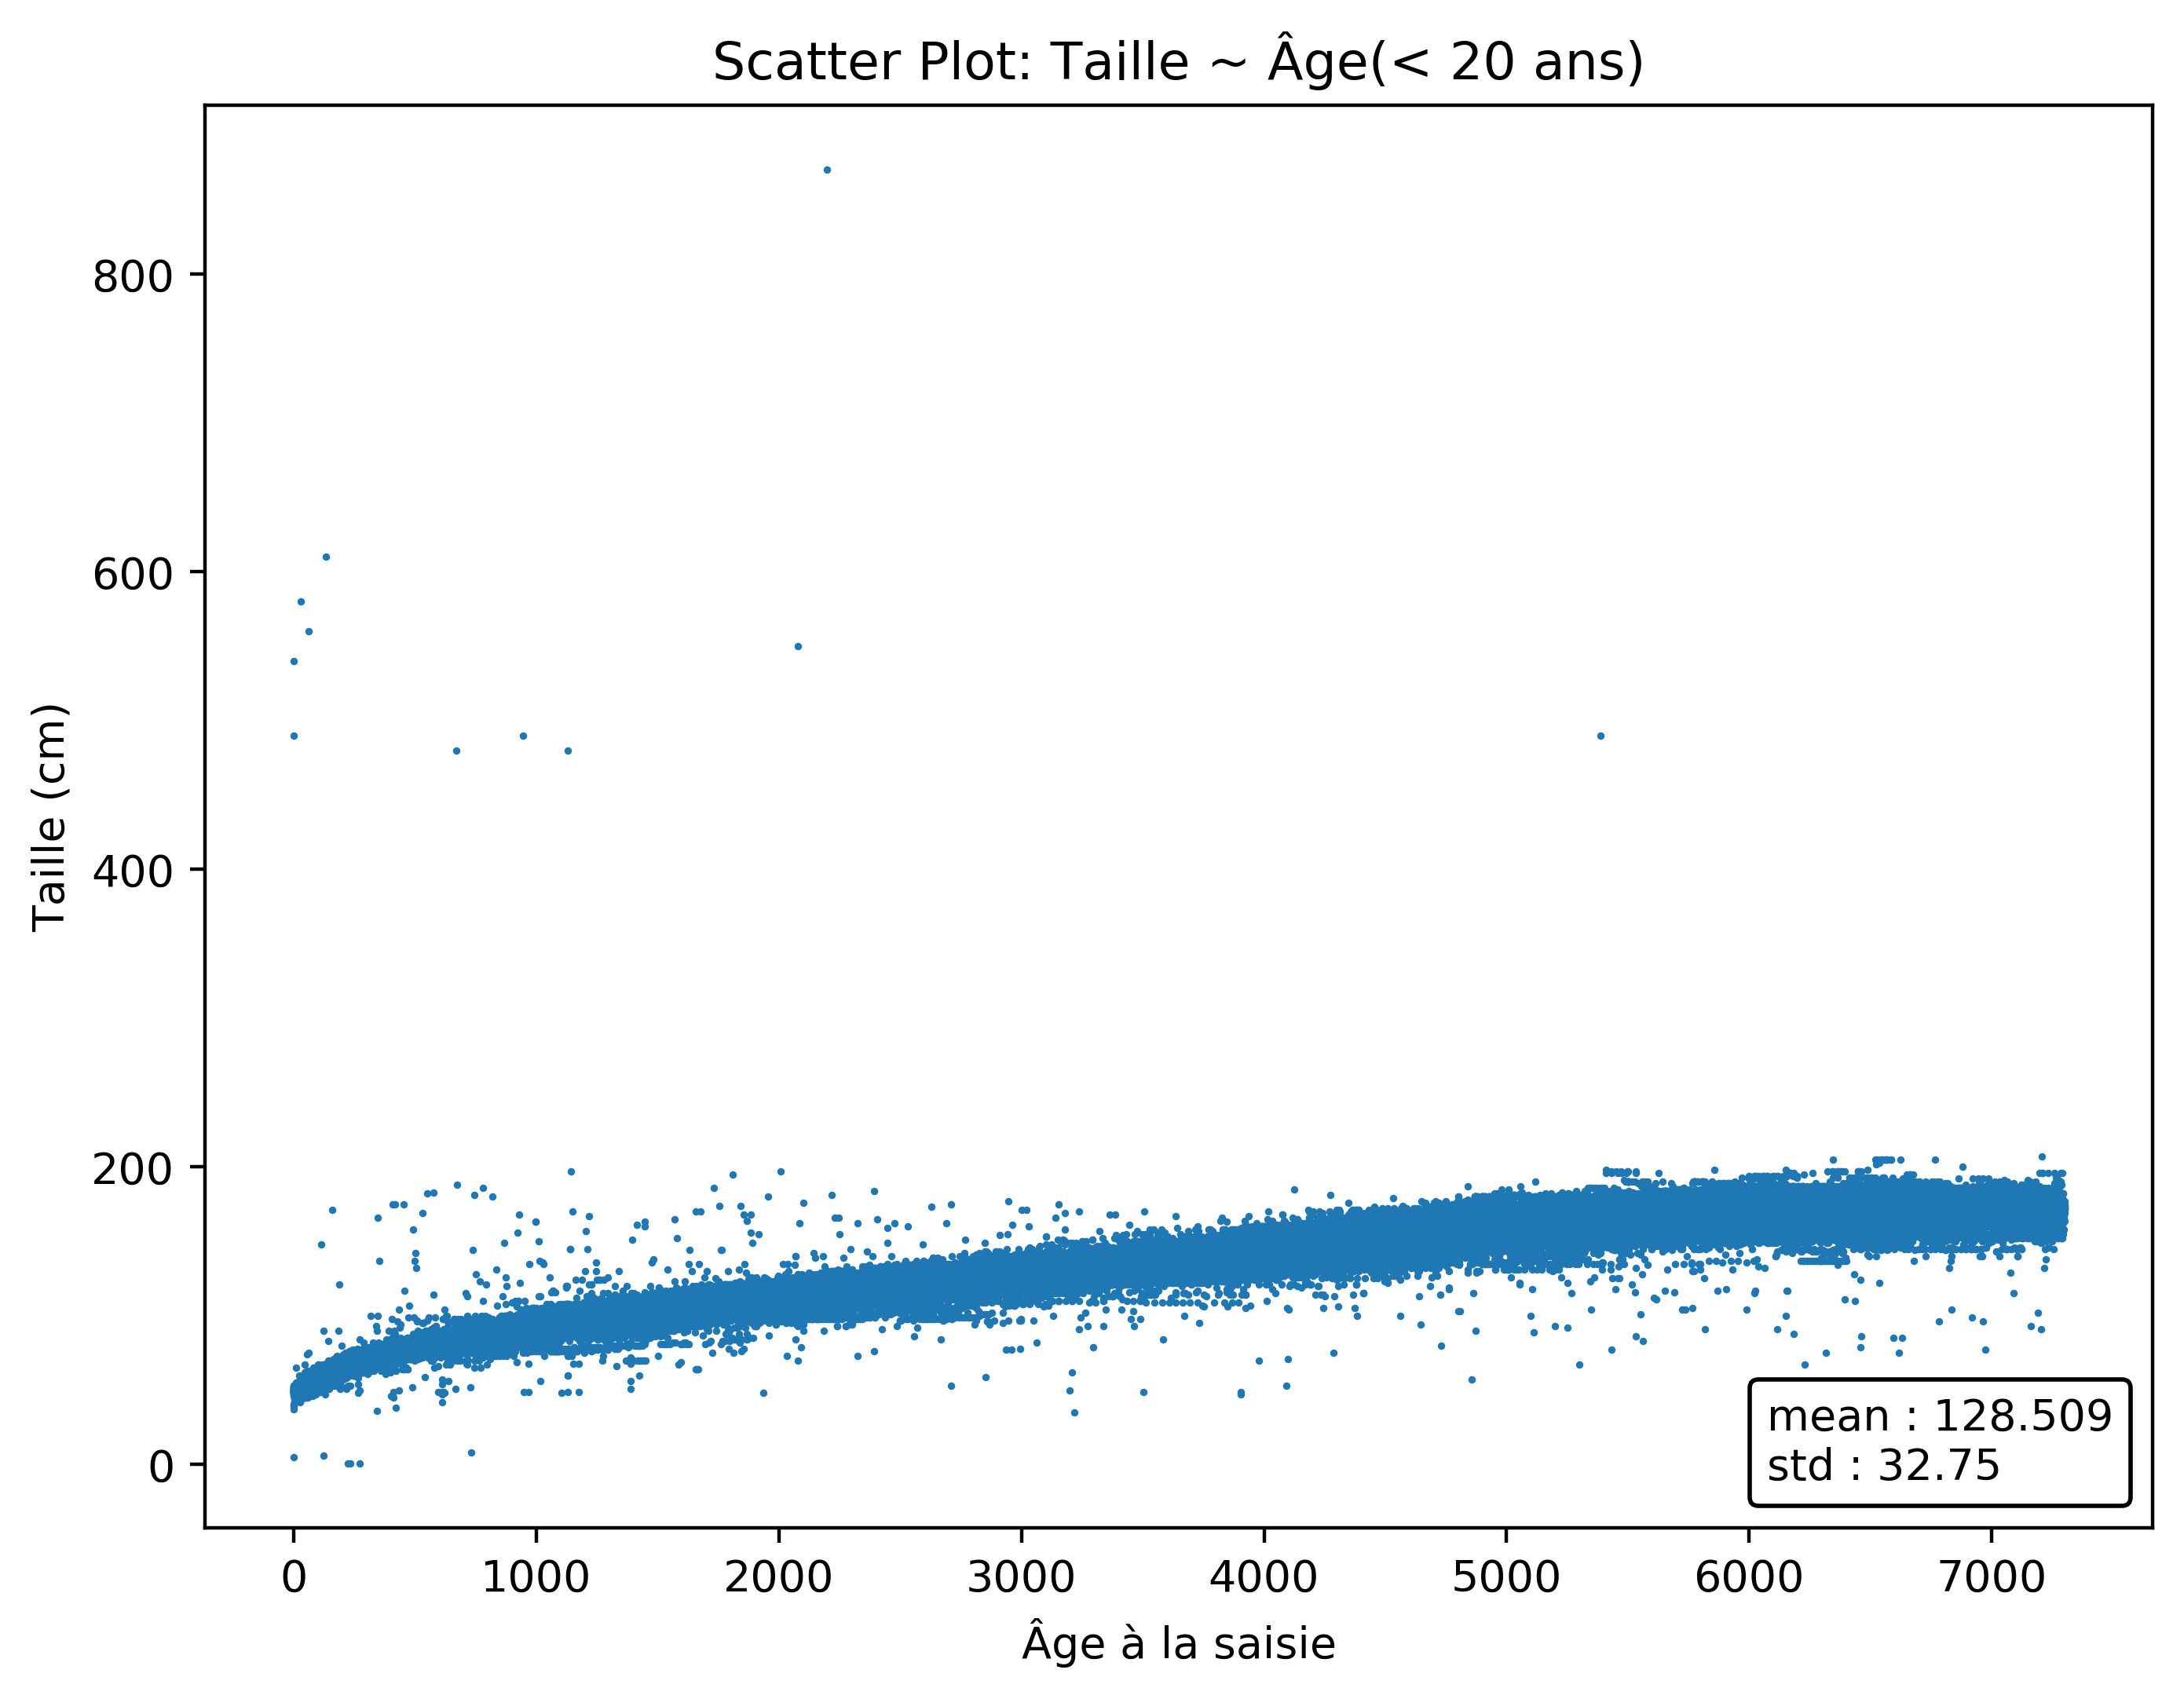

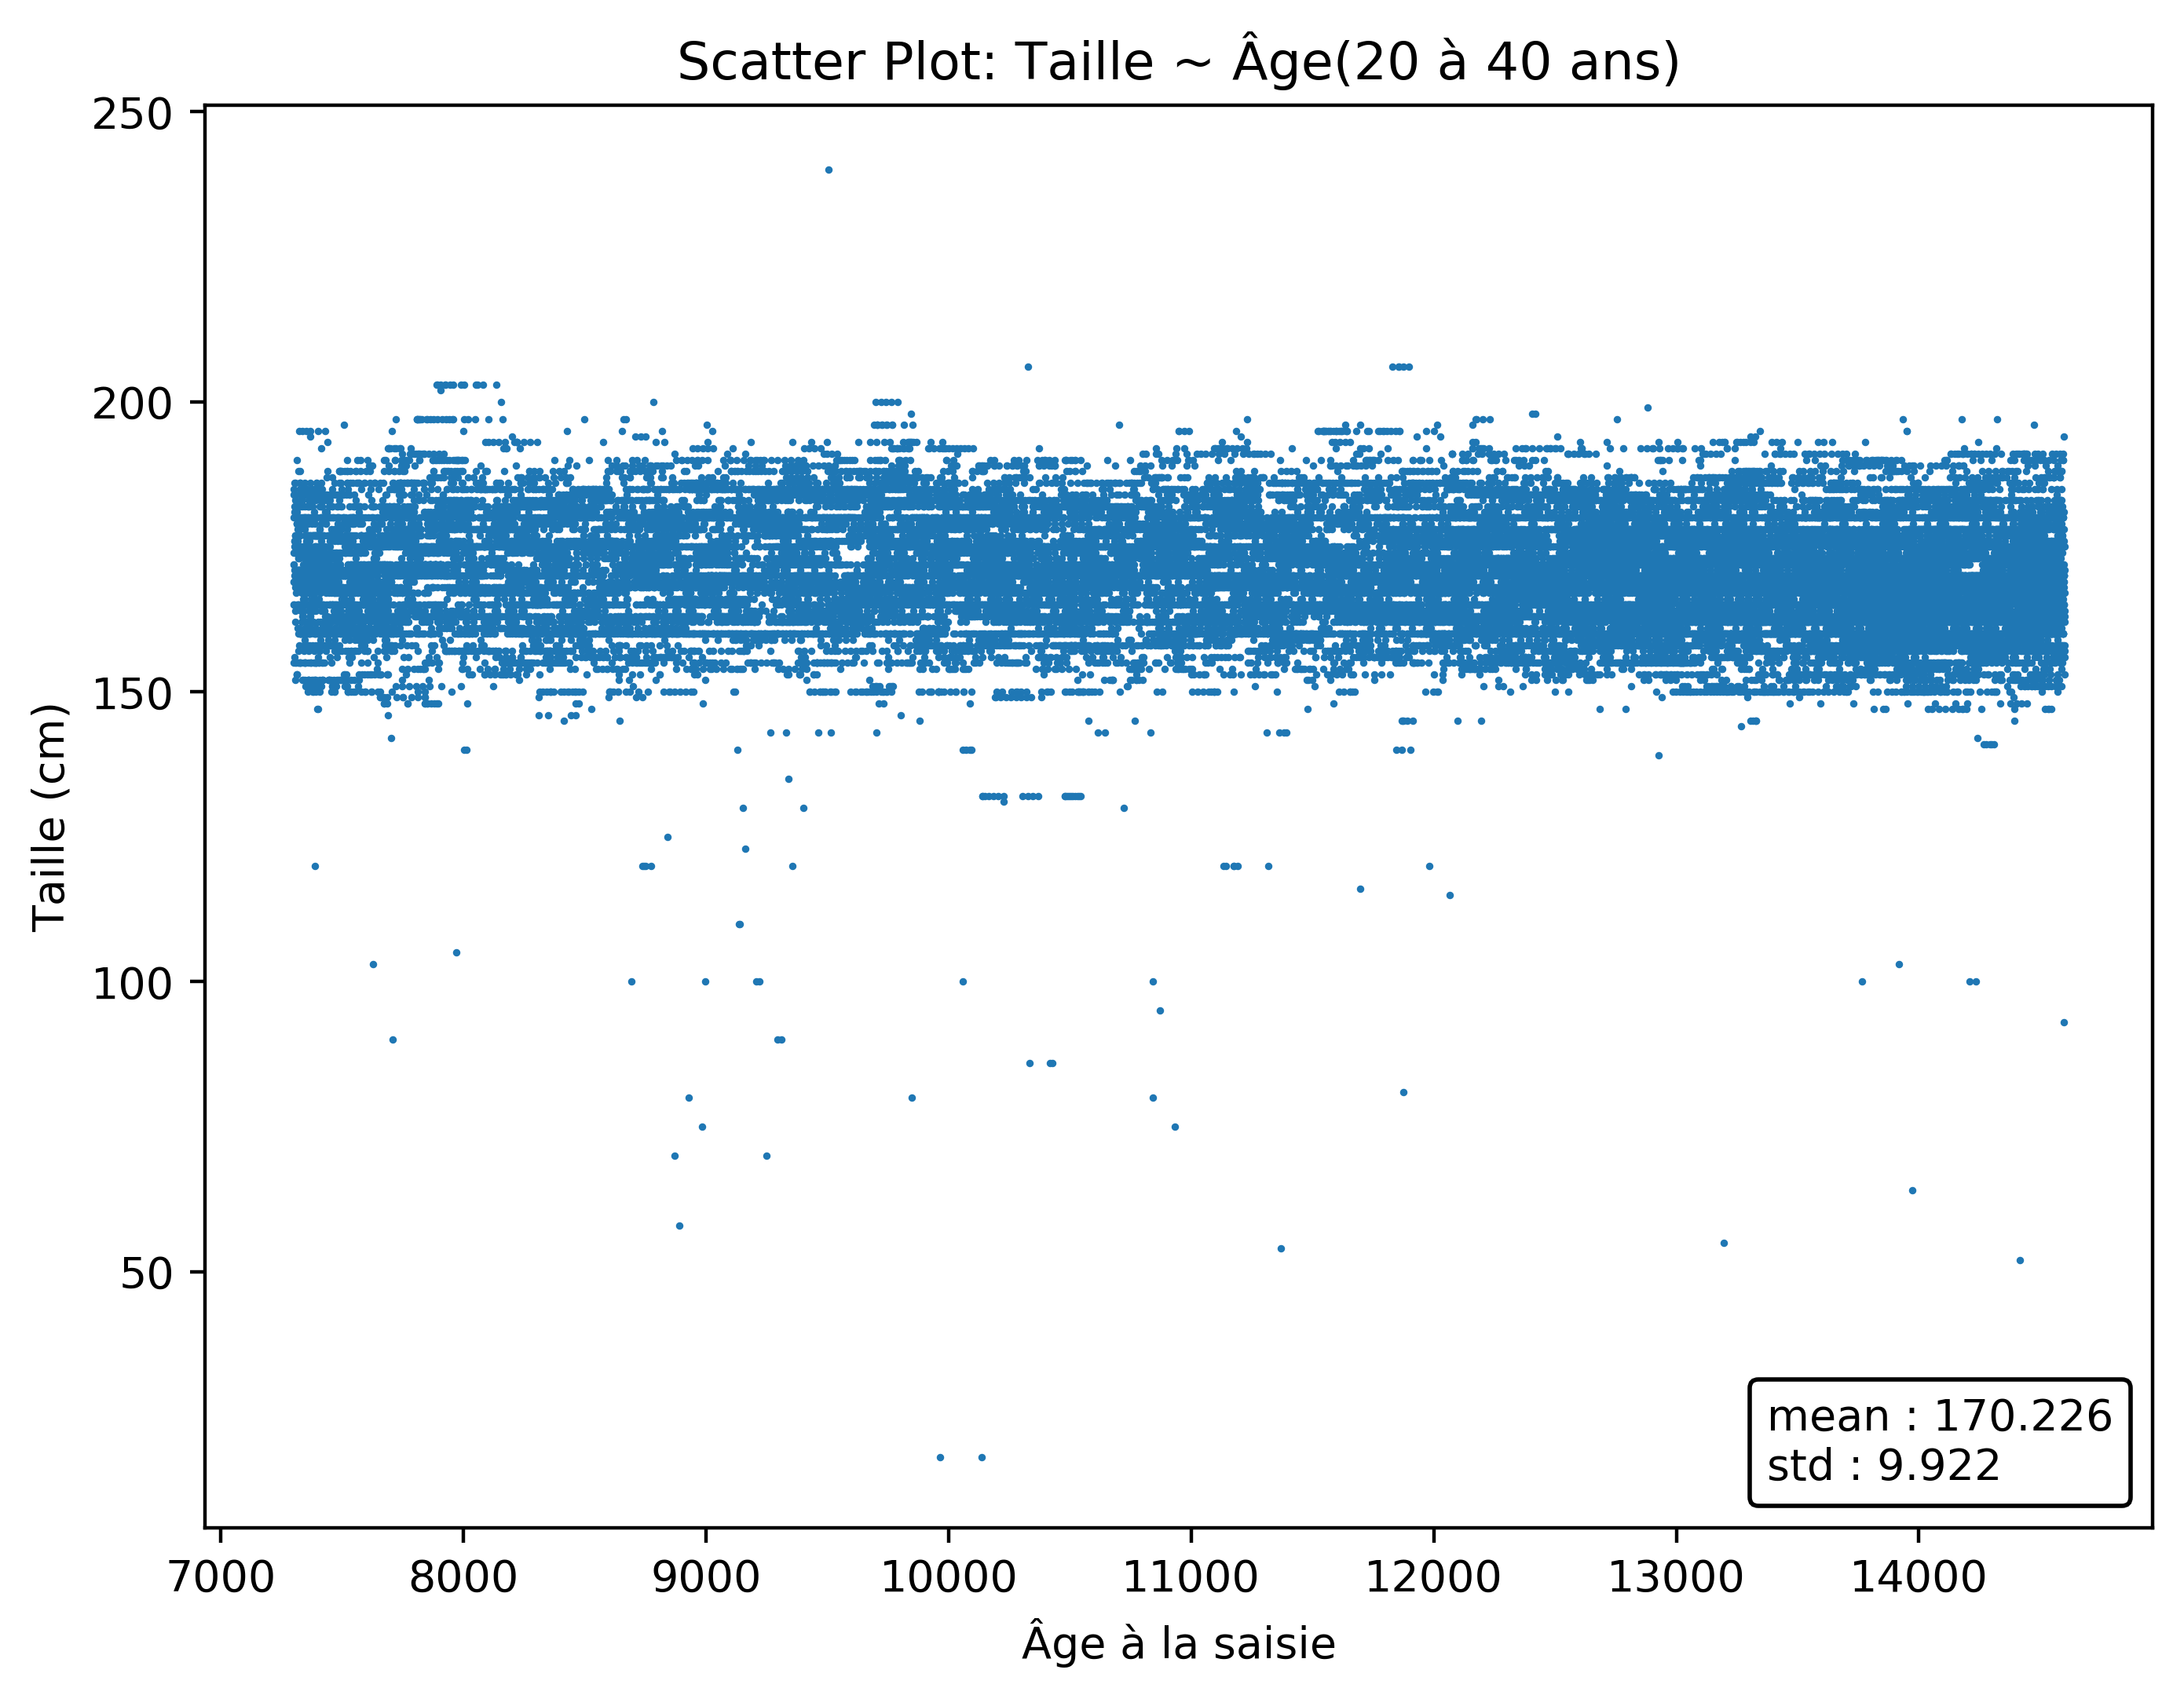

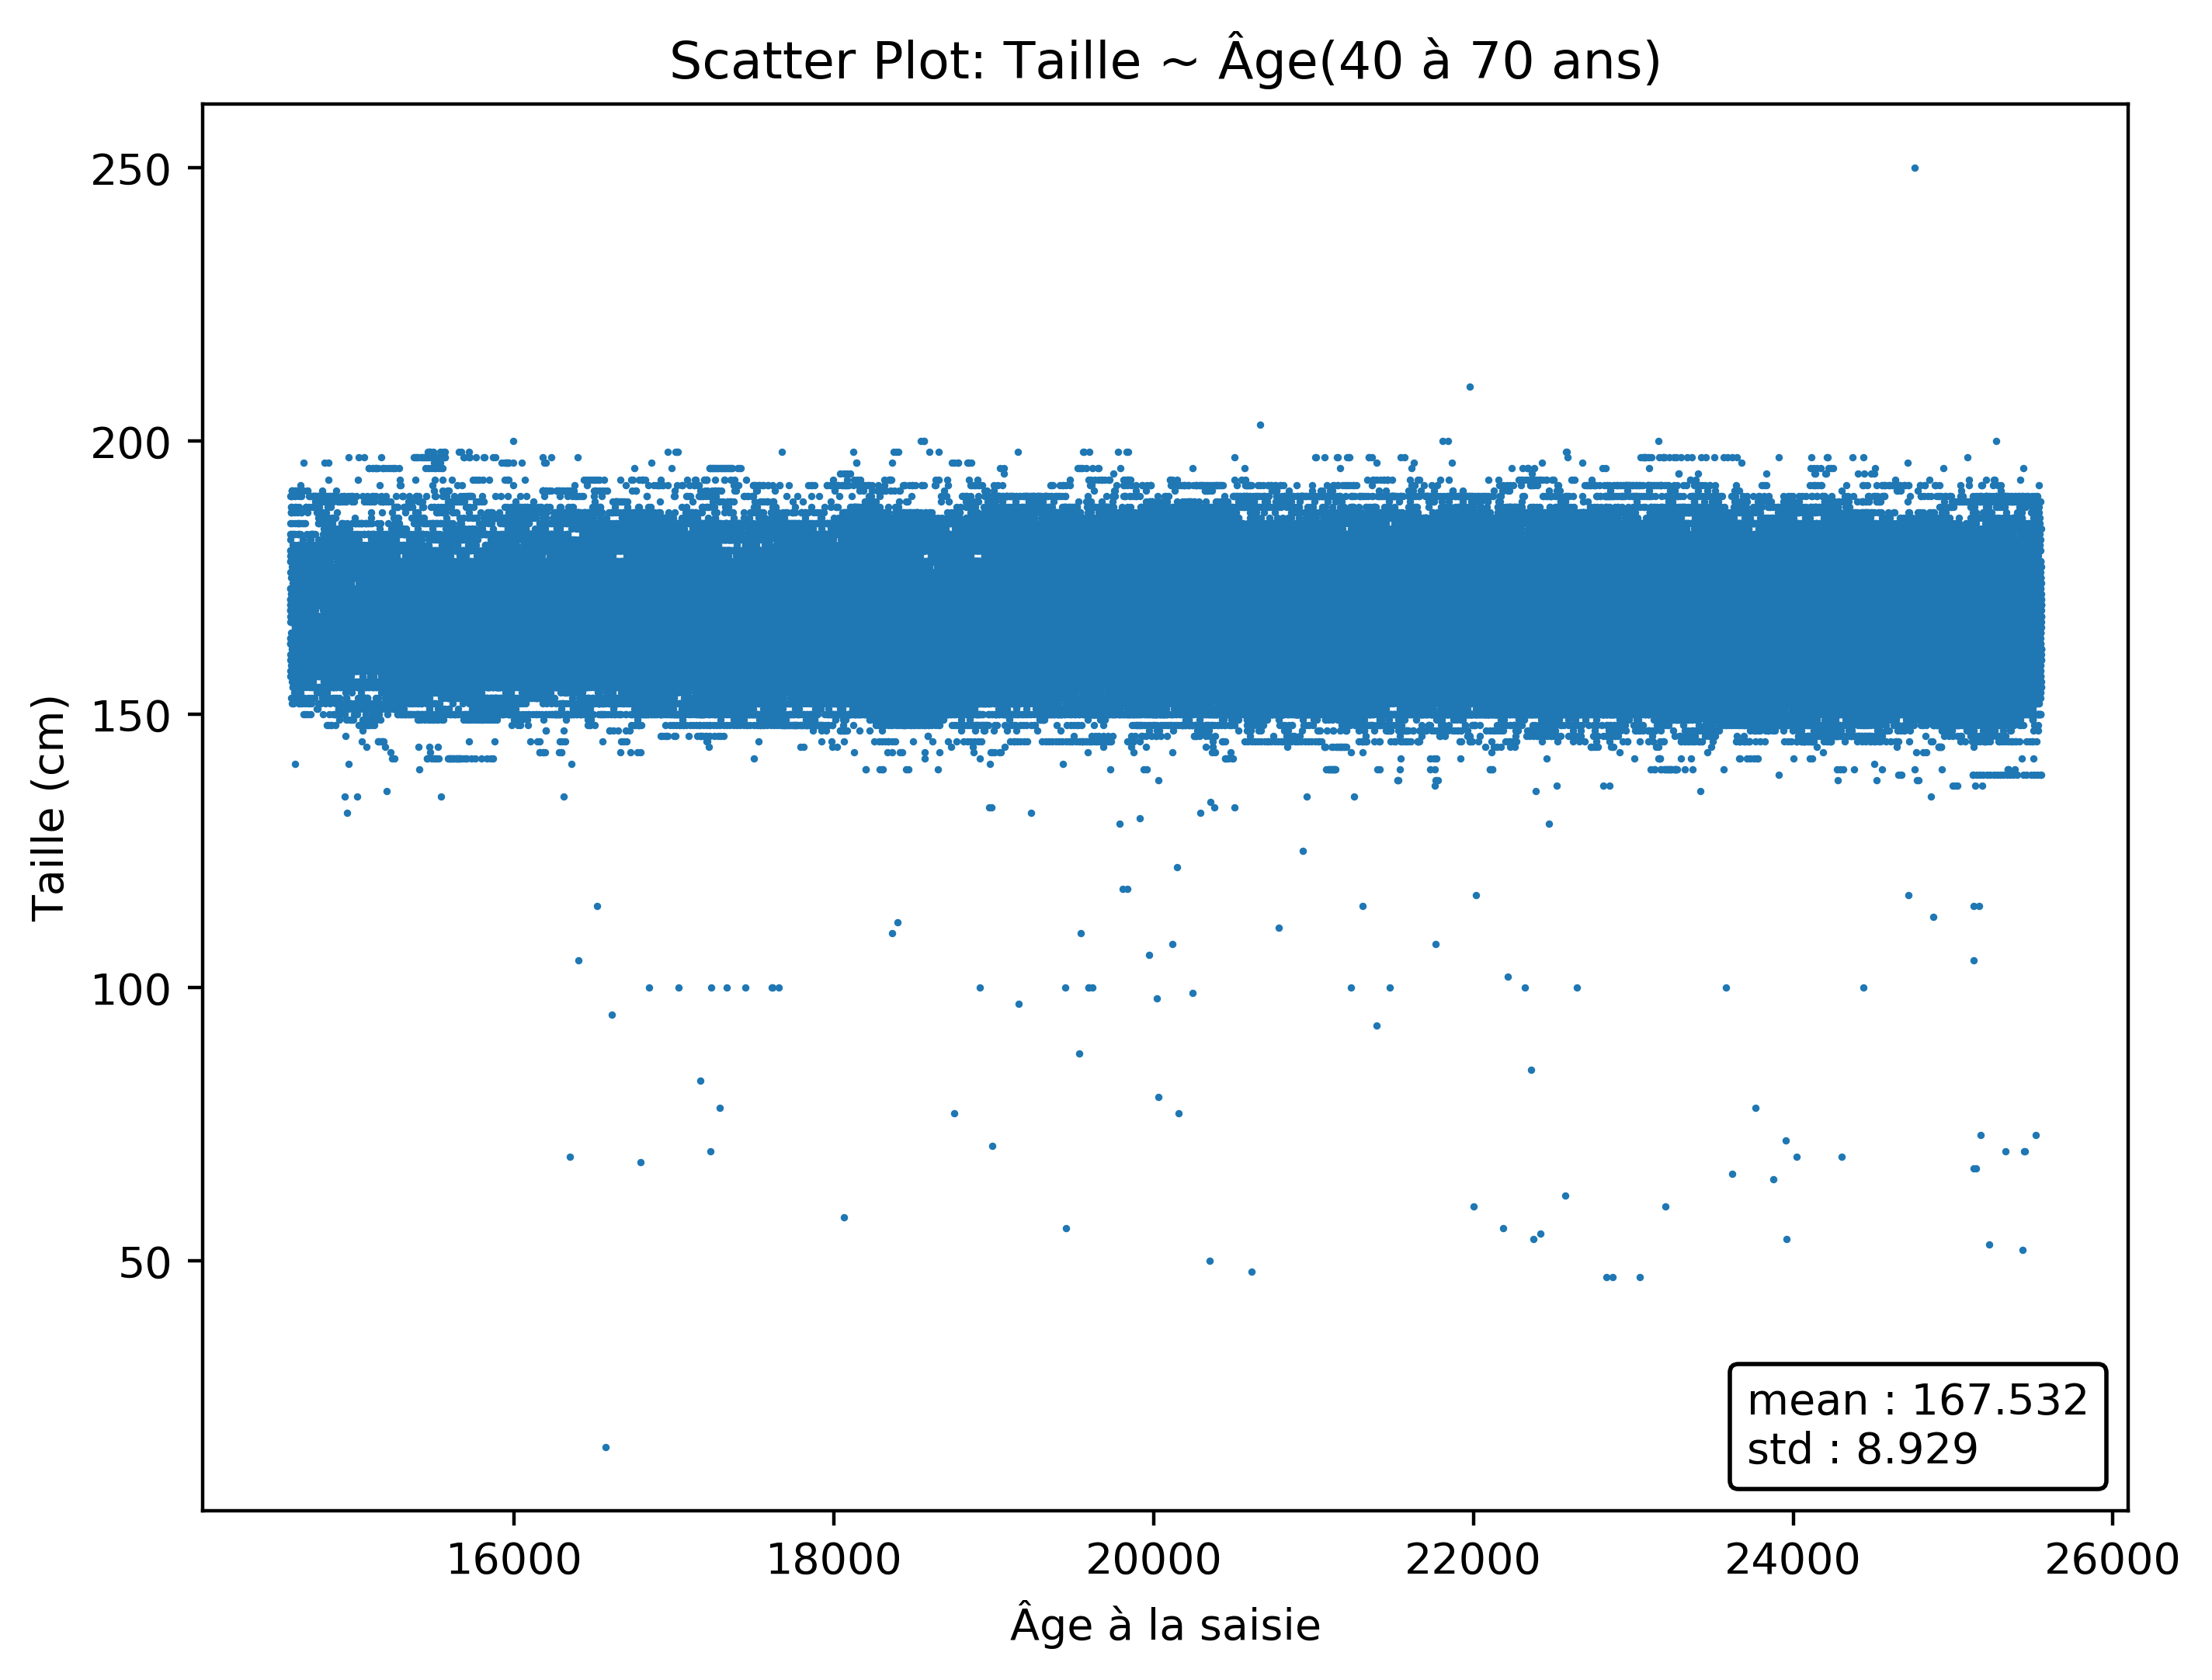

In [10]:
def scatter_plt(data, lbl):
    fig, axes = plt.subplots(figsize=[8, 6], dpi=400)
    datax = data.iloc[:, [1, 4]]
    x = data['age_at_entry']
    y = data['Taille']
    #print(datax)
    #sns.heatmap(datax, color='green', ax=axes)
    axes.plot(markersize=2)
    h = axes.scatter(x, y, s=0.5)
    axes.set_title("Scatter Plot: Taille ~ Âge" + lbl)
    axes.set_ylabel("Taille (cm)")
    axes.set_xlabel("Âge à la saisie")

    mean = data['Taille'].mean()
    std = data['Taille'].std()
    m_s_lbl = "mean : " + str(round(mean,3)) + "\nstd : " + str(round(std,3))
    at = AnchoredText(m_s_lbl,
              prop=dict(size=10), frameon=True,
              loc='lower right',
              )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    axes.add_artist(at)
    plt.show

scatter_plt(data20_70, '(> 20 ans)')
scatter_plt(data20, '(< 20 ans)')
scatter_plt(data20_40, '(20 à 40 ans)')
scatter_plt(data40_70, '(40 à 70 ans)')

### Recherche des patients avec des données extrêmes de Taille [(^)](#up)

In [15]:
# Recherche des patients
outliers = data20_70[data20_70['Taille'] < 80]
print(outliers.iloc[:5, [1,4]])
print('...')
# for ippr in outliers.IPPR:
#    data_ippr = data[data['IPPR'] == ippr]
#    print(str(ippr))
#    print()
#    print(data_ippr.iloc[:, 4])

# for ippr in outliers.IPPR:
#     data_ippr = data[data['IPPR'] == ippr]
#     print(data_ippr.Taille)
#     limit = data[data['IPPR'] == ippr].iloc[:, 4].max()
#     if outliers[outliers['IPPR'] == ippr].iloc[0][4] < limit:
#         outliers[outliers['IPPR'] == ippr].iloc[0][4] + 100
# print(outliers.Taille)

       age_at_entry  Taille
2530          22417    55.0
5465          19453    56.0
15236         22572    62.0
18344         25228    53.0
76042         26452    55.0
...


<a id="scatter02-interpret"></a>

## Interpretation des résultats [(^)](#up)
-----------

<a id="heatmap"></a>

## Heatmap > 20 ans [(^)](#up)
------------------
Scatter plot de toute les données de taille pour les patients de plus de 20 ans. 

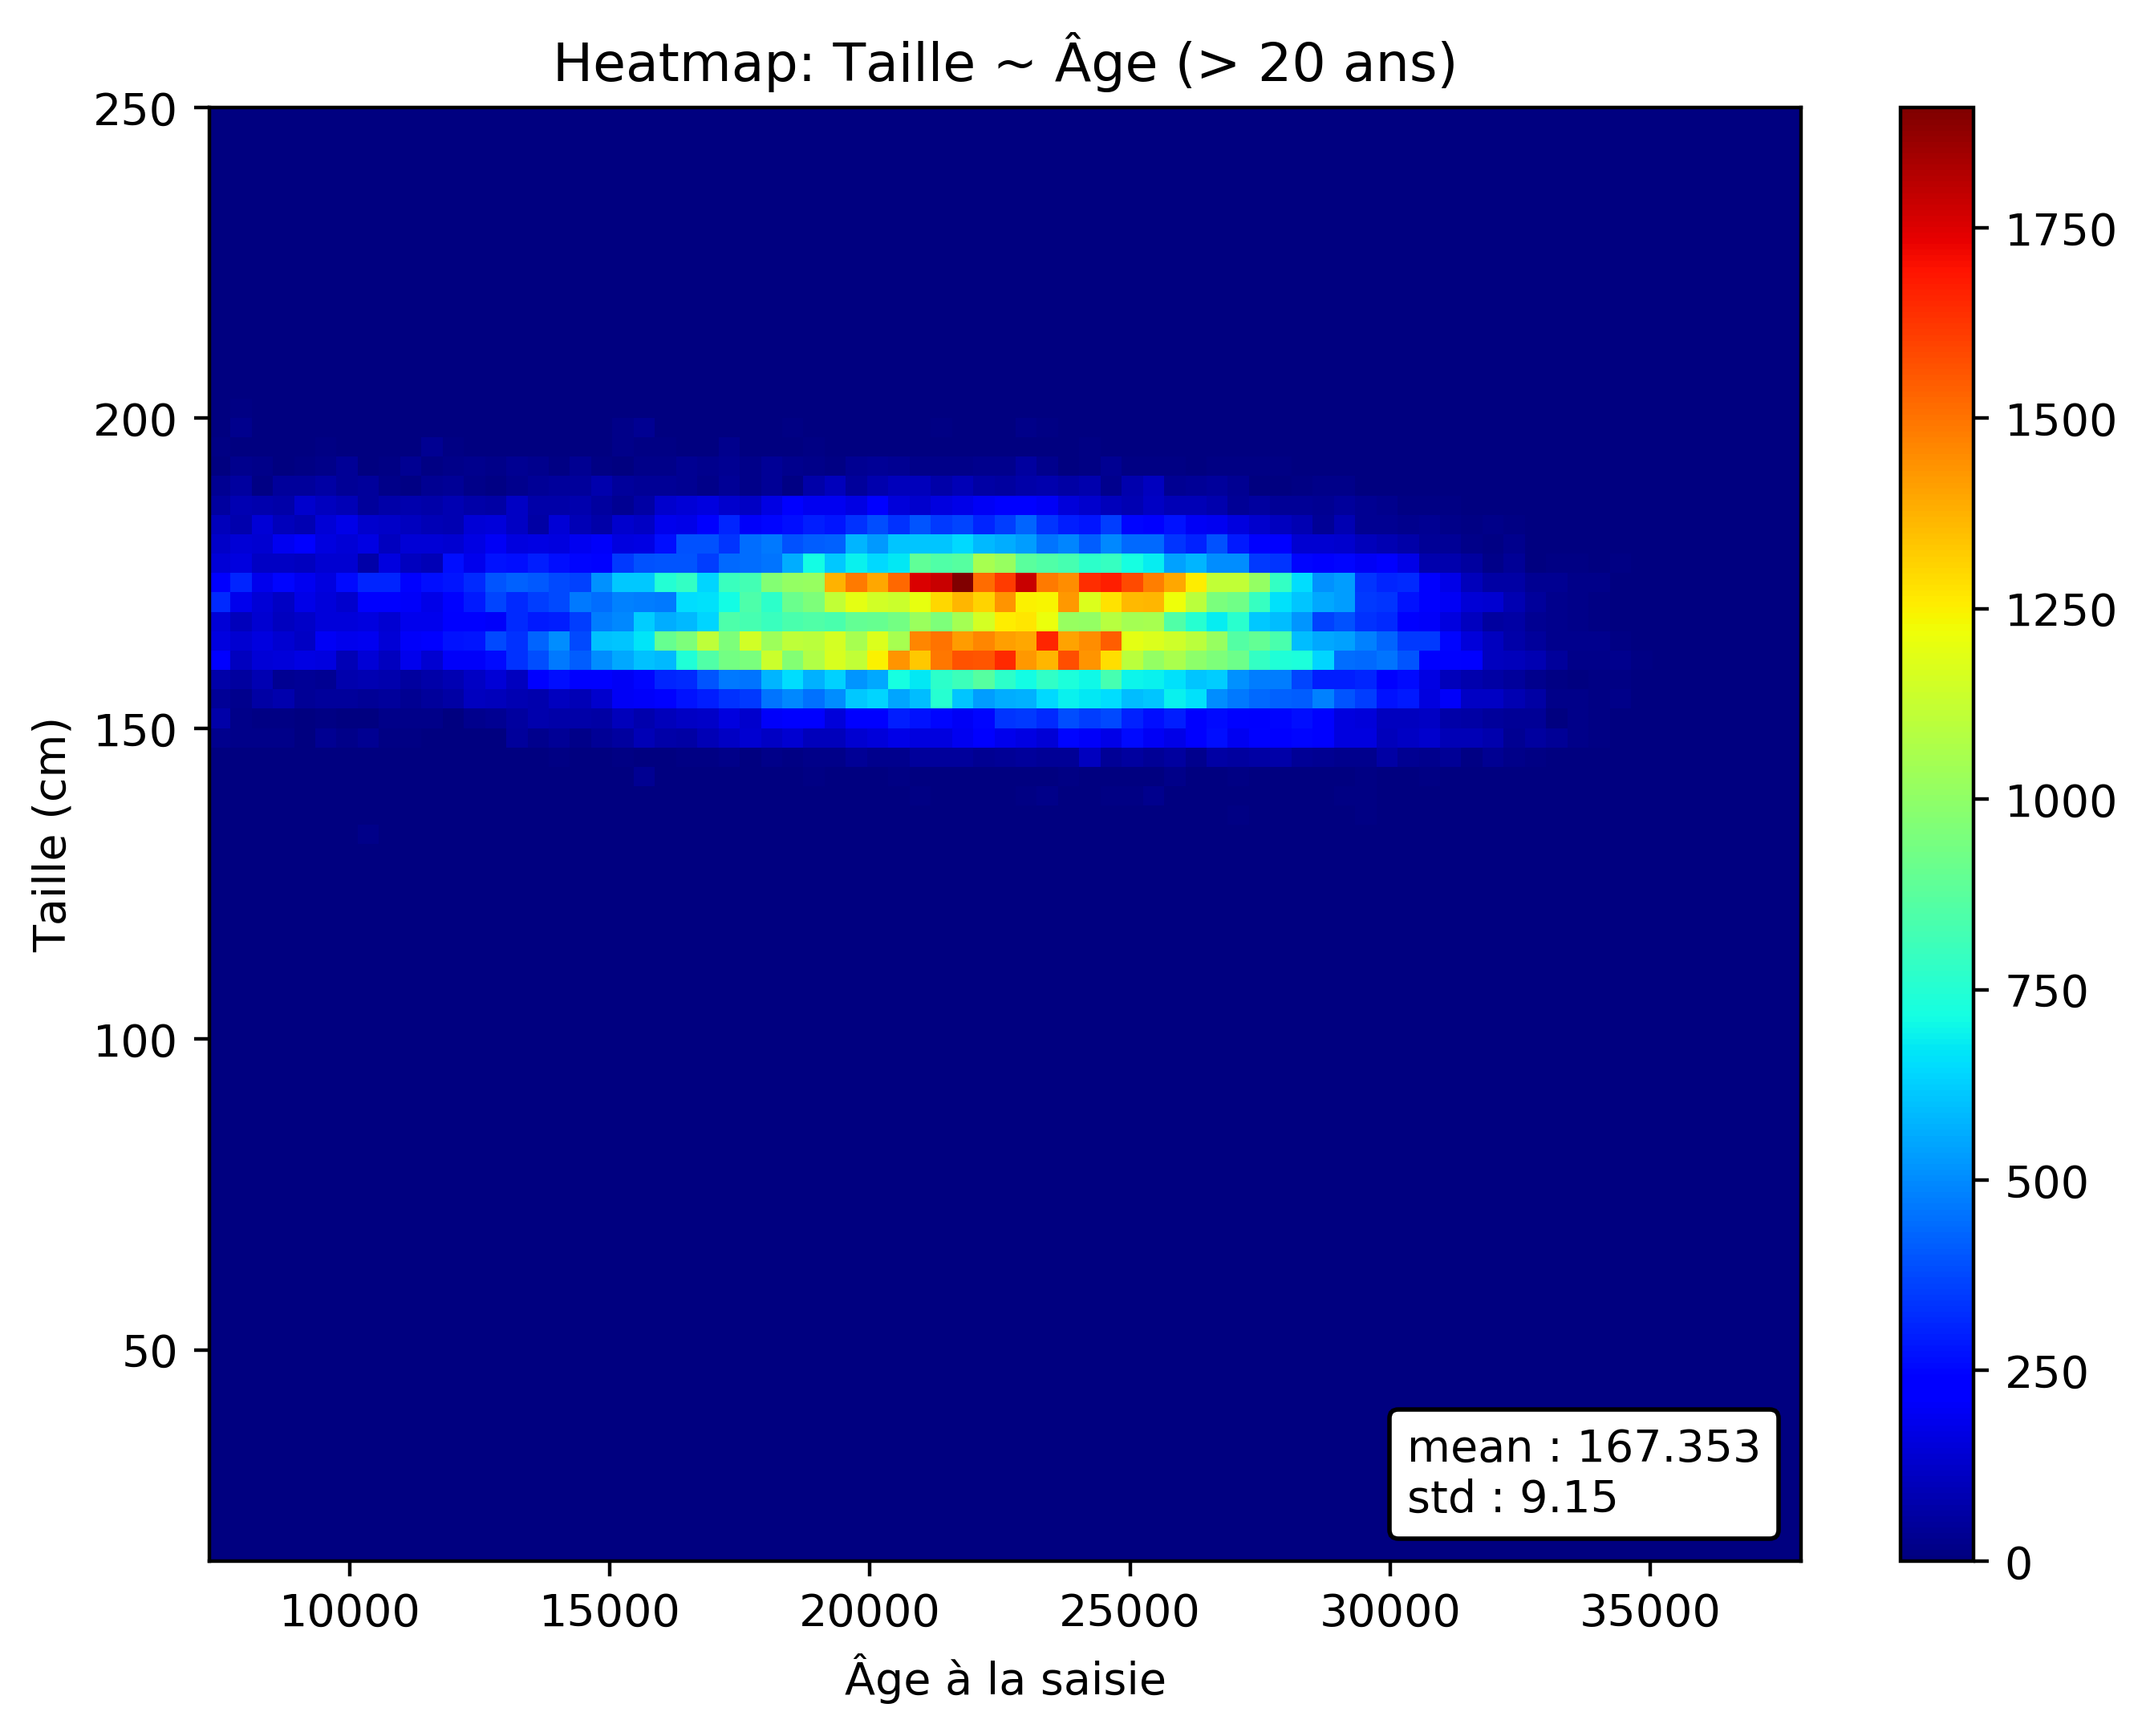

In [6]:
def hist_2d(data):
    fig, axes = plt.subplots(figsize=[8, 6], dpi=400)
    datax = data.iloc[:, [1, 4]]
    x = data['age_at_entry']
    y = data['Taille']
    #print(datax)
    #sns.heatmap(datax, color='green', ax=axes)
    h = axes.hist2d(x, y, bins=75, cmap=plt.cm.jet)
    plt.colorbar(h[3], ax =axes)
    axes.set_title("Heatmap: Taille ~ Âge (> 20 ans)")
    axes.set_ylabel("Taille (cm)")
    axes.set_xlabel("Âge à la saisie")

    mean = data['Taille'].mean()
    std = data['Taille'].std()
    m_s_lbl = "mean : " + str(round(mean,3)) + "\nstd : " + str(round(std,3))
    at = AnchoredText(m_s_lbl,
              prop=dict(size=10), frameon=True,
              loc='lower right',
              )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    axes.add_artist(at)
    plt.show
    
hist_2d(data20_70)

<a id='to-do'></a>

## À faire [(^)](#up)
-----------
- Régression Linéaire
- Analyse ANOVA
- Plot : représentation des résidus en fonction des valeurs ajustées

In [7]:
stop = timeit.default_timer()
print()
print('Time:  ', str(round(stop - start, 4)), 's\n\t' + str(round((stop - start) / 60, 4)) + ' m ')


Time:   14.7966 s
	0.2466 m 
